# Correlations

In this notebook, we'll explore correlations in single cell two-photon imaging data as well as extracellular recordings.

### By the end of this lesson, you'll be able to:
- Pull signal correlation and distance information from the Brain Observatory dataset.
- Use `imshow` and `scatter` to inspect and plot these data.
- Grab data from the Allen Neuropixels dataset, and look for correlations between cells.

### Table of Contents
1. [Part One: Correlations in two-photon imaging data](#one)
2. [Part Two: Correlations in extracellular recordings](#two)

In [1]:
!pip install --upgrade pip
!pip install allensdk

In [2]:
# Allen specific toolboxes
import allensdk.brain_observatory.stimulus_info as stim_info
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

# Additional toolboxes
import numpy as np
import pandas as pd
import scipy as sp

# Plotting setup
%config InlineBackend.figure_format = 'retina' # Improve the resolution of our plots!
%matplotlib inline
import matplotlib.pyplot as plt

<a id="one"></a>

## Part I. Correlations in two-photon imaging data.

### Step 1. Create a BrainObservatoryCache object and create a dataframe of experiments
Just as we did in the Brain Observatory notebook, here we'll choose a visual_area and cre_line and look at all of the experiments that meet that criteria.


<font color='red'>**Note**: You need to run this notebook in the Docker container that includes allen-brain-observatory (often denoted by 'w/ allen'). Otherwise you will get a permissions error when you attempt to run the cell below.</font>

In [3]:
# We will create an instance of the Brain Observatory Cache as an object, "boc."
boc = BrainObservatoryCache(manifest_file='/datasets/allen-brain-observatory/visual-coding-2p/manifest.json')

# Choose a visual area and cre-line
visual_area = 'VISp'
cre_line ='Cux2-CreERT2'

# Get the experiment containers for that visual area & cre line
exps = boc.get_experiment_containers(targeted_structures=[visual_area], cre_lines=[cre_line])

# Make a dataframe and look at it to remind ourselves what's in here.
exps = pd.DataFrame(exps)
exps.head()

,id,imaging_depth,targeted_structure,cre_line,reporter_line,donor_name,specimen_name,tags,failed
0,511510736,175,VISp,Cux2-CreERT2,Ai93(TITL-GCaMP6f),222426,Cux2-CreERT2;Camk2a-tTA;Ai93-222426,[],False
1,511510855,175,VISp,Cux2-CreERT2,Ai93(TITL-GCaMP6f),229106,Cux2-CreERT2;Camk2a-tTA;Ai93-229106,[],False
2,511509529,175,VISp,Cux2-CreERT2,Ai93(TITL-GCaMP6f),222420,Cux2-CreERT2;Camk2a-tTA;Ai93-222420,[],False
3,511507650,175,VISp,Cux2-CreERT2,Ai93(TITL-GCaMP6f),222424,Cux2-CreERT2;Camk2a-tTA;Ai93-222424,[],False
4,702934962,275,VISp,Cux2-CreERT2,Ai93(TITL-GCaMP6f),382421,Cux2-CreERT2;Camk2a-tTA;Ai93-382421,[],False


### Step 2. Choose a specific experiment
For our exercise today, we'll take a look at correlations in a field of view from two-photon imaging data. Let's first look at data that was collected while mice were viewing natural scenes.

In [4]:
# Get the first experiment container id
expt_container_id = exps['id'][0]

# Get the first session id
session_id = boc.get_ophys_experiments(
    experiment_container_ids=[expt_container_id],
    stimuli=['natural_scenes'])[0]['id']

### Step 3. Get the computed signal correlation
To do so, we'll use `get_ophys_experiment_analysis()` to import an analysis object as `ns`. This object contains many computed metrics, such as the signal correlation between single neurons (the `signal_correlation` attribute of our `ns` object).

In [5]:
# Import the natural scenes analysis
ns = boc.get_ophys_experiment_analysis(ophys_experiment_id=session_id, stimulus_type='natural_scenes')

# Get the signal correlation
sc = ns.signal_correlation

2025-07-24 19:46:55,546 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514429113
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514429113
2025-07-24 19:47:06,597 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/517090750
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/517090750


<div class="alert alert-success">
    <b>Task</b>: Look at the shape of the <code>sc</code> object we created above. Why is it that shape? (Hint: look at the available methods and attributes from <code>ns</code> for additional information about this dataset.)
</div>

<div class="alert alert-success">

<b>Task</b>: Now that we have an idea of what this <code>sc</code> object is, visualize it using <code>plt.imshow()</code>. What should the x and y axes be labeled here?

</div>

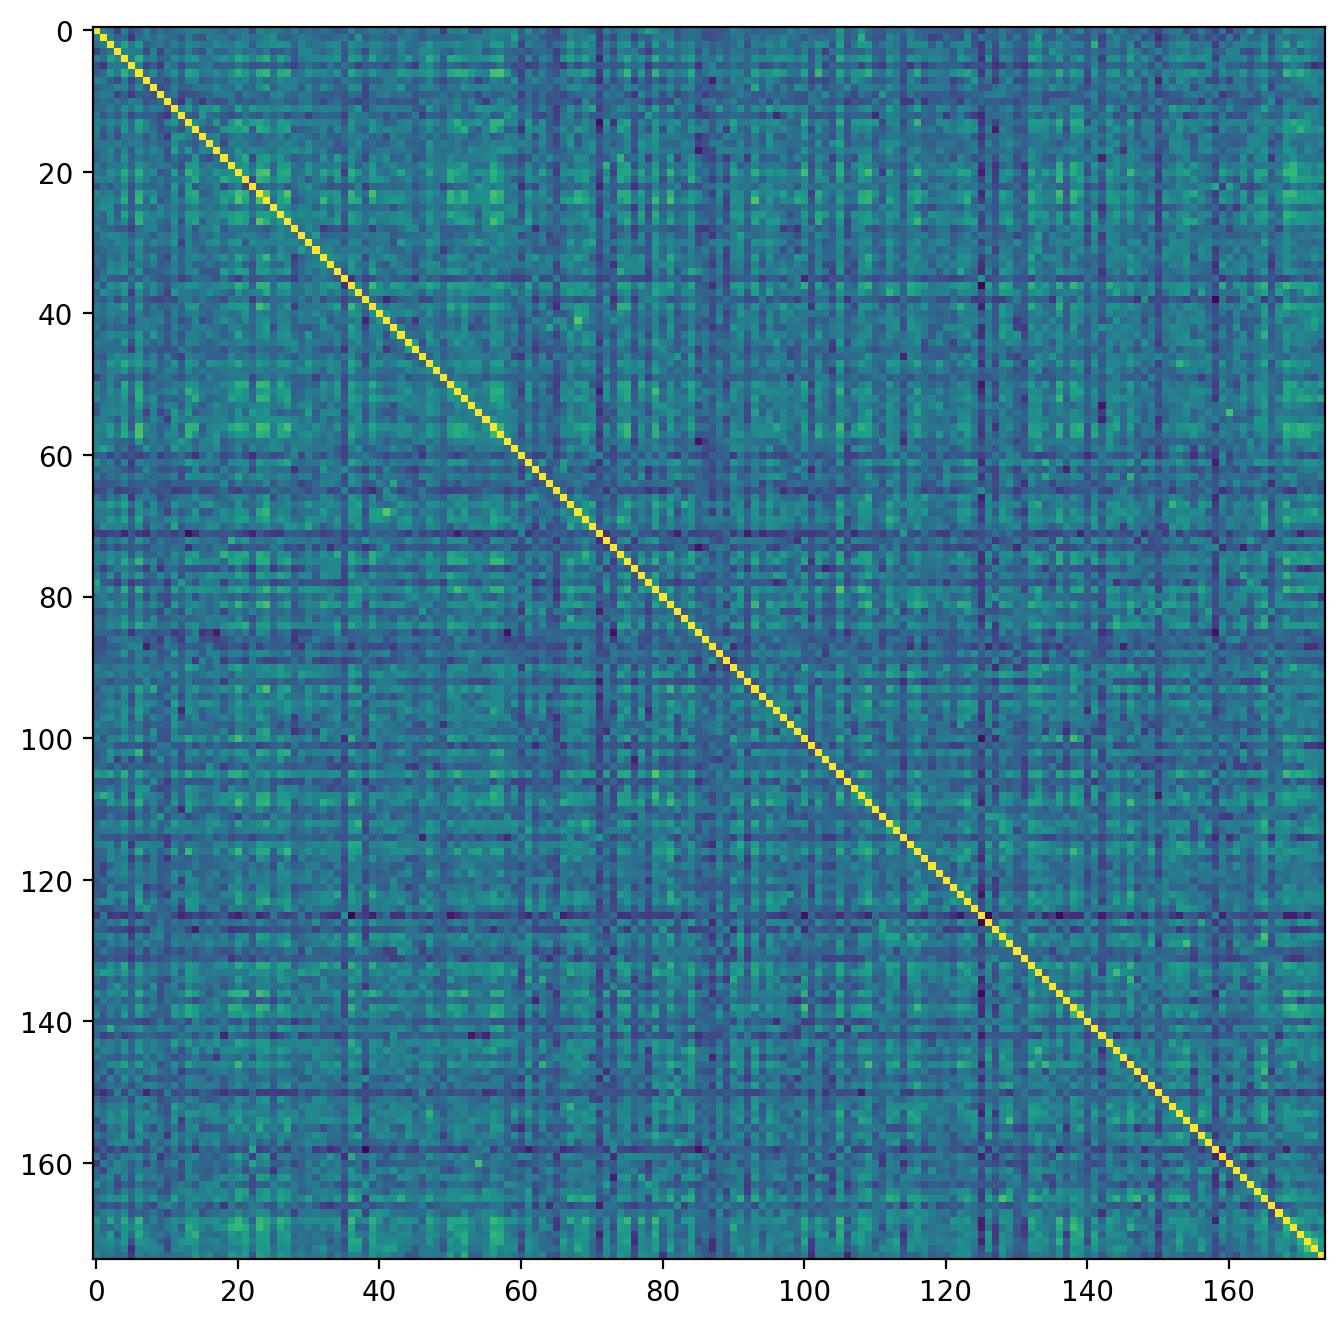

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))
im = plt.imshow(sc)

### Step 4. Look at the raw data for this experiment
So some of these cells are correlated more than other cells -- you might wonder whether how *far* the cells are from eachother actually predicts these correlations. To figure this out, we first need to calculate the distance between cells in our field of view. To remind us that we're looking down at a bunch of cells, let's look at the maximum projection of all of the imaging in this session.

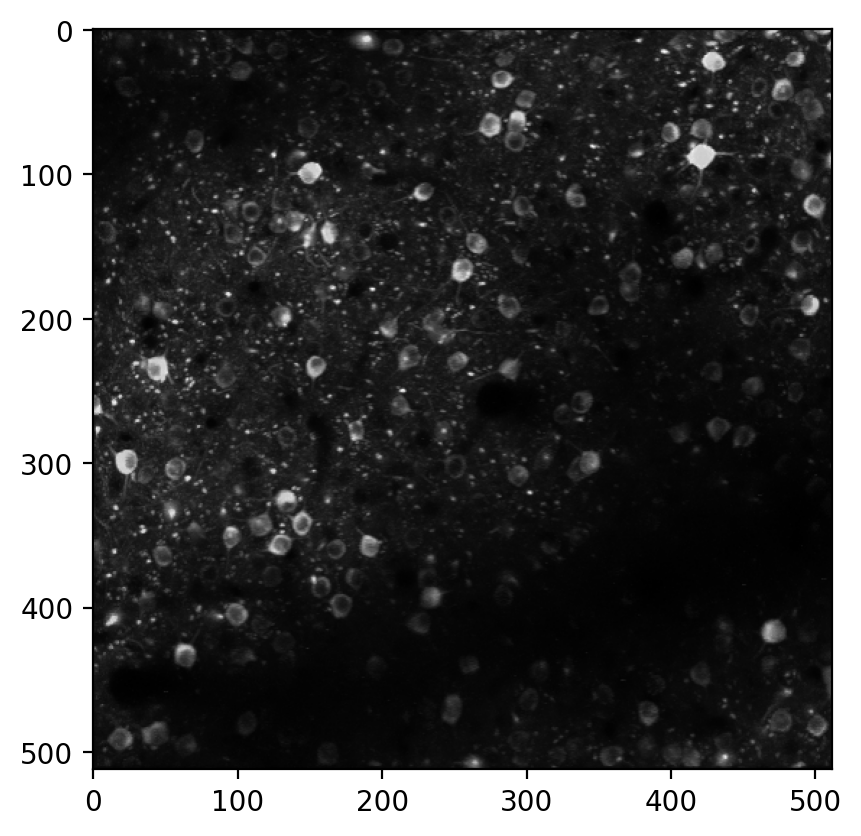

In [9]:
# Get the max projection of the data and show it
dataset = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)
max_proj = dataset.get_max_projection()
plt.imshow(max_proj, cmap='gray')
plt.show()

### Step 5. Get the regions of interest
In the block below, we'll get the regions of interest (ROIs) using the `get_roi_mask_array()` method on our dataset.

In [10]:
rois = dataset.get_roi_mask_array()

### Step 6. Calculate distance between ROIs
Now we can calculate the distance between our ROIs, using simple geometric distance. This distance that we calculate will be in "pixels" of the image -- we'd need to know the size of our field of view in order to get this into actual units of distance.

In [11]:
num_cells = rois.shape[0]
loc_x = np.zeros((num_cells))
loc_y = np.zeros((num_cells))

for i in range(num_cells):
    ind = np.where(rois[i])
    loc_x[i] = np.mean(ind[1])
    loc_y[i] = np.mean(ind[0])

distance = np.zeros((num_cells, num_cells))
for i in range(num_cells):
    for j in range(num_cells):
        distance[i, j] = np.sqrt( (loc_x[i]-loc_x[j])**2 + (loc_y[i]-loc_y[j])**2 )

### Step 7. Plot the distance matrix between cells.

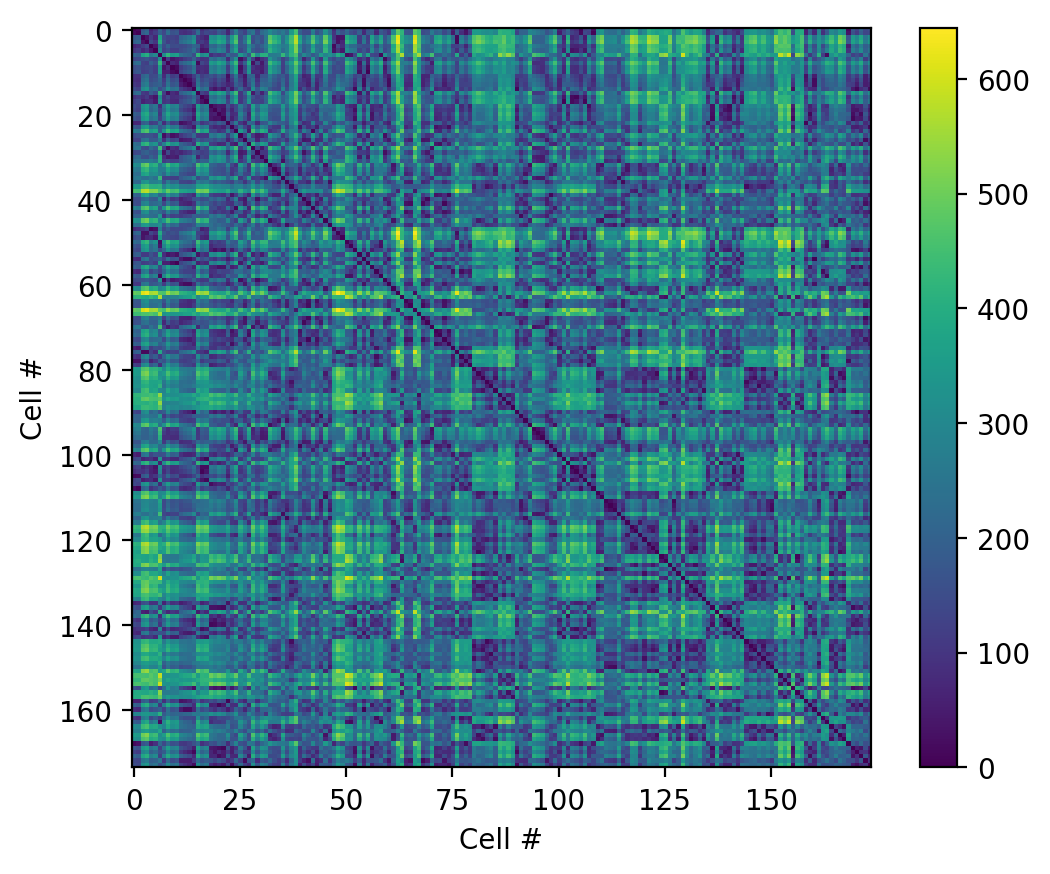

In [12]:
# Plot the distance matrix
plt.imshow(distance)
plt.xlabel("Cell #")
plt.ylabel("Cell #")
plt.colorbar()
plt.show()

### Step 8. Plot the distribution of distances.
Below, we'll plot the distribution of distances. Importantly, we only count each distance once, so we'll use a numpy function called <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.triu_indices.html">triu_indices</a> to get the x and y indices of the the values. Be sure to eliminate the diagonal itself)
    </div>

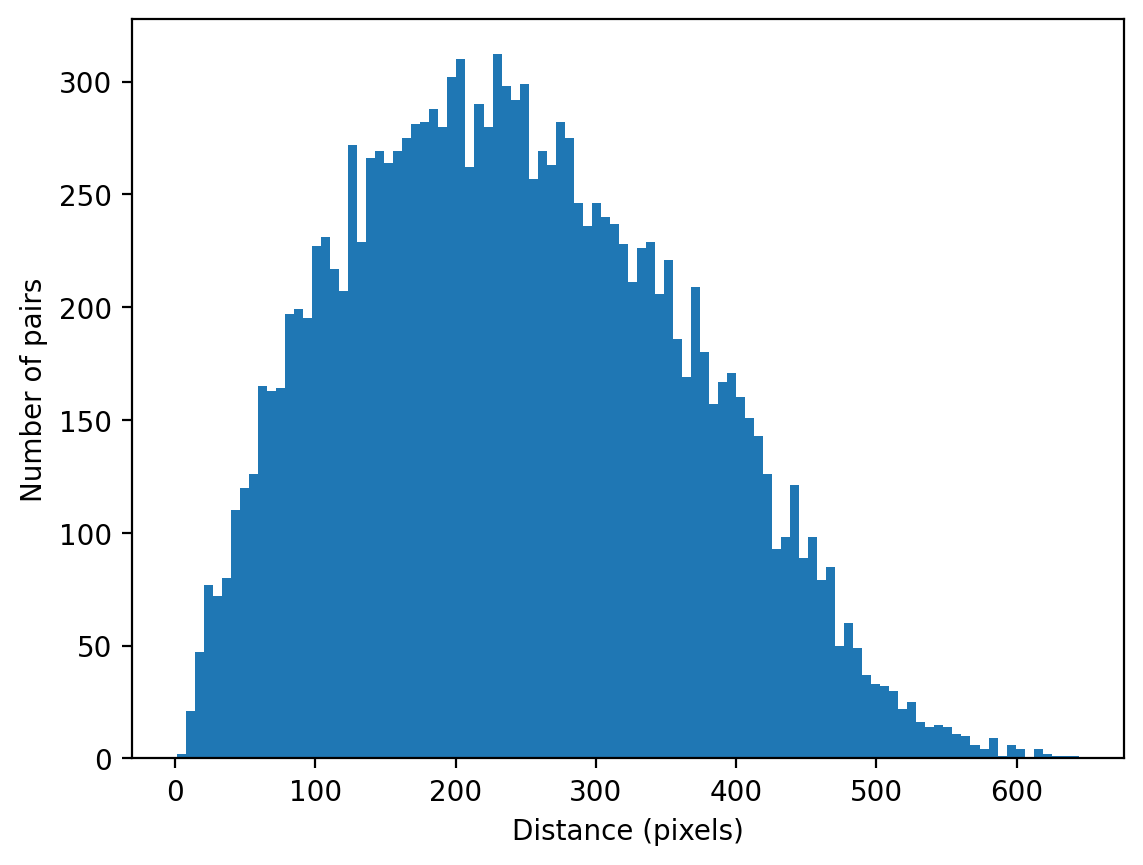

In [13]:
inds = np.triu_indices(num_cells, k=1)
distance_vector = distance[inds[0], inds[1]]
plt.hist(distance_vector, bins=100)
plt.xlabel("Distance (pixels)")
plt.ylabel("Number of pairs")
plt.show()

### Step 9. See if there is a relationship between distance and signal correlation!
<div class="alert alert-success">

<b>Task</b>: Plot the distance versus the single cell correlation values, to see if they correlate. Add this where indicated.
</div>

After plotting your scatterplot, there is code below to calculate the linear least squares regression of these data, using `scipy.stats.linregress()` ([documentation here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html)).


r_value: -0.141410    p_value: 0.000000
pearson's r: -0.141410    pearson's p: 0.000000


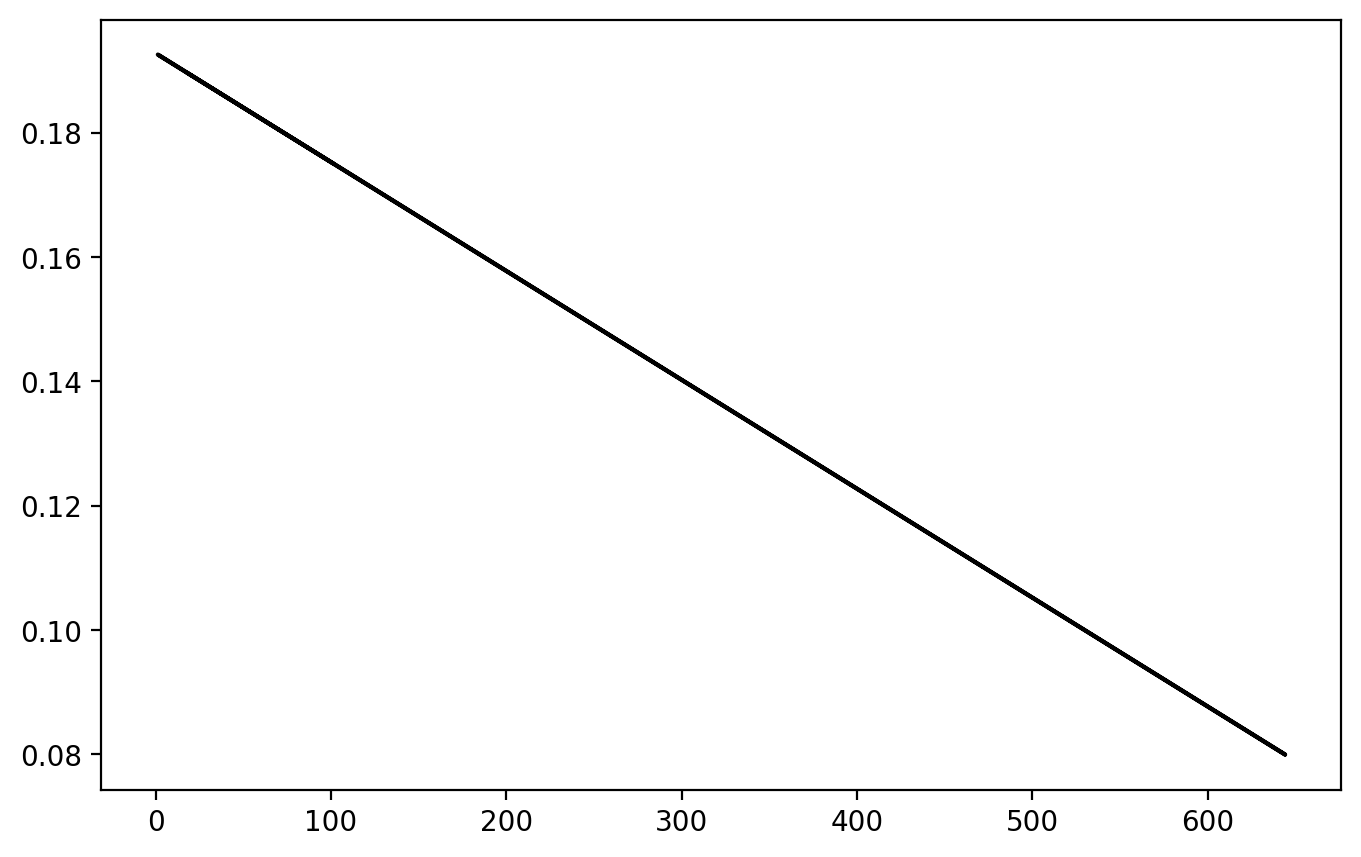

In [14]:
plt.figure(figsize=(8,5))

# YOUR SCATTER PLOT HERE

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(distance_vector, sc[inds[0], inds[1]])
plt.plot(distance_vector,intercept+slope*distance[inds[0], inds[1]],"k-")
print("r_value: %f    p_value: %f" % (r_value, p_value))

# Calculate the Pearson's correlation
pearsons_r , pearsons_p = sp.stats.pearsonr(distance_vector, sc[inds[0], inds[1]])
print("pearson's r: %f    pearson's p: %f" % (pearsons_r, pearsons_p))

<a id="two"></a>

## Part II: Correlations in extracellular recordings

We can also look at correlations between cells in extracellular recordings.

### Step 1. Get the Neuropixels data.
As always, we first need to get the data! To do so, we have two options:

#### Option 1: From the data stored on the DataHub.
This option requires that the DataHub is updated, and that you're running this from the DataHub.

In [15]:
# To do this with data stored on the datahub

# Import the Neuropixels Cache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# We have all of this data on the datahub! This is where it lives.
manifest_path = '/datasets/allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/manifest.json'

# Create the EcephysProjectCache object
cache = EcephysProjectCache.fixed(manifest=manifest_path)

AttributeError: 'EcephysProjectFixedApi' object has no attribute 'rma_engine'

#### Option 2: Directly from the Allen
If we don't have the data on the DataHub, we can instead pull it directly from the Allen's data storage. This takes some time as well as some data storage space (just over 50 MB), so if possible, the above option should be chosen. See additional details in the documentation and Data Access notebook found [here](https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html).

In [16]:
# To do this by pulling data from the Allen SDK

# Import the Neuropixels Cache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

manifest_path = 'neuropixels/manifest.json'
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

### Step 2. Look at what is available in this dataset, and pull relevant sessions.

In [17]:
# Get the sessions available in this dataset
sessions = cache.get_session_table()
sessions.head()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"


These data contain recordings across many visual areas (see column "ecephys_structure_acroynyms" above).

For the sake of continuity, let's just look at experiments that contain the same area we looked at in Part I.

In [18]:
# Create a session list based on some criteria
session_list = []

for idx,structure_list in enumerate(sessions['ecephys_structure_acronyms']):
    if visual_area in structure_list:
        session_list.append(sessions.index[idx])

print('There are '+str(len(session_list))+' sessions that meet this criteria:')
print(session_list)

There are 56 sessions that meet this criteria:
[715093703, 719161530, 721123822, 732592105, 737581020, 739448407, 742951821, 743475441, 744228101, 746083955, 750332458, 750749662, 751348571, 754312389, 754829445, 755434585, 756029989, 757216464, 757970808, 758798717, 759883607, 760345702, 760693773, 761418226, 762120172, 762602078, 763673393, 766640955, 767871931, 768515987, 771160300, 771990200, 773418906, 774875821, 778240327, 778998620, 779839471, 781842082, 786091066, 787025148, 789848216, 791319847, 793224716, 794812542, 797828357, 798911424, 799864342, 816200189, 821695405, 829720705, 831882777, 835479236, 839068429, 839557629, 840012044, 847657808]


Let's just look at the first experiment session, and get that data using `get_session_data()`. We will then get the response to drifting gratings using the `get_stimulus_table()` method on our session object.

<font color='red'>**Note**: <code>get_session_data()</code> will download a ~2 GB file. This will take a while, unfortunately.</font>

In [19]:
session_id = session_list[0]
session = cache.get_session_data(session_id)
drift = session.get_stimulus_table('drifting_gratings')
drift.head()

Downloading:   0%|          | 0.00/2.86G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


,stimulus_block,start_time,stop_time,stimulus_name,spatial_frequency,contrast,temporal_frequency,phase,orientation,size,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,2.0,1574.774823,1576.776513,drifting_gratings,0.04,0.8,4.0,"[21211.93333333, 21211.93333333]",315.0,"[250.0, 250.0]",2.00169,246
3799,2.0,1577.777347,1579.779027,drifting_gratings,0.04,0.8,8.0,"[21211.93333333, 21211.93333333]",90.0,"[250.0, 250.0]",2.00168,247
3800,2.0,1580.779833,1582.781563,drifting_gratings,0.04,0.8,2.0,"[21211.93333333, 21211.93333333]",225.0,"[250.0, 250.0]",2.00173,248
3801,2.0,1583.782367,1585.784047,drifting_gratings,0.04,0.8,2.0,"[21211.93333333, 21211.93333333]",90.0,"[250.0, 250.0]",2.00168,249
3802,2.0,1586.784883,1588.786553,drifting_gratings,0.04,0.8,8.0,"[21211.93333333, 21211.93333333]",135.0,"[250.0, 250.0]",2.00167,250


### Step 3. Get the spike counts for a drifting grating stimulus.
We need to do a little bit of wrangling to get the spike counts for our drifting grating stimulus.

In [3]:
# get the info about the drifting gratings session
first_drift_id = drift.index.values[0]
first_drift_duration = drift.loc[first_drift_id, "stop_time"] - drift.loc[first_drift_id, "start_time"]

# construct the time domain at 10 ms resolution
time_step = 1 / 100
time_domain = np.arange(0.0, first_drift_duration + time_step, time_step)

histograms_drift = session.presentationwise_spike_counts(
    bin_edges=time_domain,
    stimulus_presentation_ids=drift.index,
    unit_ids=None
)

NameError: name 'drift' is not defined

In [2]:
spike_counts_drift = histograms_drift[0]
max_len=spike_counts_drift.shape[0]

# get two spike trains in drifting gratings activity
spike_train_1_drift=spike_counts_drift[:max_len, 81]
spike_train_2_drift=spike_counts_drift[:max_len, 83]

# plot the spike trains for which the correlogram will be computed

fig, ax = plt.subplots(1, 2,figsize=(10,4))

ax[0].plot(spike_train_1_drift)
ax[0].set_ylabel('Spike count 1')
ax[0].set_xlabel('Time bins (10 ms)')

ax[1].plot(spike_train_2_drift)
ax[1].set_ylabel('Spike count 2')
ax[1].set_xlabel('Time bins (10 ms)')
plt.show()

NameError: name 'histograms_drift' is not defined

In [ ]:
# compute the correlogram for spontaneous activity
xcorr_drift=sp.signal.correlate(spike_train_1_drift,spike_train_2_drift)

# time steps
time_shift_drift=np.arange(-len(xcorr_drift)/2,len(xcorr_drift)/2,1)

Now that we've computed the cross-correlations between our spike trains, we can plot the data.

In [ ]:
# plot the cross-correlations for drifting gratings

plt.figure(figsize=(14,8))
plt.plot(time_shift_drift,xcorr_drift)
plt.ylabel('Signal correlation')
plt.xlabel('Time steps (10 ms)')
plt.title('Drifting gratings')
plt.show()

<div class="alert alert-success">

<b>Task</b>:
1. Find two cells that are clearly correlated in time.
2. Change the brain area we are looking at -- are spikes more or less correlated there?
3. Instead of looking for correlations in response to drifting gratings, look for responses during spontaneous sessions ('spontaneous' in <code>sessions.get_stimulus_table()</code>).
</div>

## About this notebook

Exercises here inspired by [this Brain Observatory notebook](https://github.com/AllenInstitute/SWDB_2019/blob/master/DynamicBrain/solutions/Other/BrainObservatory_solutions.ipynb) and [this Neuropixels notebook](https://github.com/AllenInstitute/SWDB_2019/blob/master/DynamicBrain/solutions/Neuropixels_exercises_solutions.ipynb) by the Allen Institute.